# Question A3

Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 20 - 30 min, so plan your time carefully.

1. Firstly, we import relevant libraries.

In [91]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [92]:
# YOUR CODE HERE
from common_utils import MLP, CustomDataset, loss_fn

### since can only submit 1 version of common_utils.py
### A3 version of the MLP class code - need to change num neurons of first layer
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            # Input Layer --> First Hidden Layer
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),

            #   for A3, `no_hidden` will refer to the num of neurons in the first layer only
            #   hence the rest of the layers are hardcoded (as seen from the advice given in the FAQ)
            #   First Hidden Layer --> Second Hidden Layer
            nn.Linear(no_hidden, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            # Second Hidden Layer --> Third Hidden Layer
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            # Third Hidden Layer --> Output Layer
            # Output layer with sigmoid activation function
            nn.Linear(128, no_labels),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.mlp_stack(x)

3. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [93]:
def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):
    # Create CustomDataset and DataLoader objects for training and validation
    train_dataset = CustomDataset(X_train_scaled, y_train2)
    train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

    val_dataset = CustomDataset(X_val_scaled, y_val2)
    val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)

    # times refer to the training time
    # but since I won't be using it, return 0 (as suggested in "Question A3" in the Discussion Board)
    times = 0
    train_accuracies = []
    train_losses = []
    test_accuracies = []
    test_losses = []

    # follow num of epochs used in previous questions
    for epoch in range(100):
      model.train()

      batch_train_loss = []
      batch_train_accuracy = []

      for X_batch, y_batch in train_dataloader:
        # follow optimizer used in previous questions
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        optimizer.zero_grad()
        # Forward pass
        y_pred = model(X_batch)

        # calculate training accuracy
        accuracy = (y_pred.round() == y_batch).float().mean()
        batch_train_accuracy.append(float(accuracy))

        # calculate training loss
        loss = loss_fn(y_pred, y_batch)
        batch_train_loss.append(loss.detach().numpy())

        loss.backward()
        optimizer.step()

      train_losses.append(sum(batch_train_loss) / len(batch_train_loss))
      train_accuracies.append(sum(batch_train_accuracy) / len(batch_train_accuracy))

      model.eval()
      batch_test_loss = []
      batch_test_accuracy = []
      with torch.no_grad():

        for X_batch, y_batch in val_dataloader:
          y_pred = model(X_batch)

          # calculate test accuracy
          accuracy = (y_pred.round() == y_batch).float().mean()
          batch_test_accuracy.append(float(accuracy))

          # calculate test loss
          loss = loss_fn(y_pred, y_batch)
          batch_test_loss.append(loss.detach().numpy())

        # Calculate mean validation loss and accuracy for the current epoch
        test_accuracies.append(sum(batch_test_accuracy) / len(batch_test_accuracy))
        test_losses.append(sum(batch_test_loss) / len(batch_test_loss))

      if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Batch Train Accuracy: {batch_train_accuracy[-1]*100:.2f}%, Batch Train Loss: {batch_train_loss[-1]}, Batch Test Accuracy: {batch_test_accuracy[-1]*100:.2f}%, Batch Test Loss: {batch_test_loss[-1]}")

    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [94]:
def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):
  # initialise dictonaries required for output
  cross_validation_accuracies = {}
  cross_validation_times = 0 # will not be using, hence it will return 0

  # Loop through each neuron num size
  for neurons in parameters:
    kfold = KFold(n_splits = 5, shuffle=True, random_state = 0)

    # list to store all the cross validation accuracies for every fold for each num of neurons
    fold_cross_validation_accuracies = []
    for t_samples, v_samples in kfold.split(X_train):
      # X_t = training data for the current fold
      X_t = X_train[t_samples]
      # y_t = corresponding target values (labels) of the training data in the current fold.
      y_t = y_train[t_samples]
      # X_v = validation data for the current fold
      X_v = X_train[v_samples]
      # y_v = corresponding target values (labels) of the validation data in the current fold.
      y_v = y_train[v_samples]

      # to scale the data
      scaler = preprocessing.StandardScaler()

      # Scale the training data and validation data
      X_t_scaled = scaler.fit_transform(X_t)
      X_v_scaled = scaler.transform(X_v)

      # initialisation of NN (MLP takes the neuron value for first layer)
      model = MLP(77, neurons, 1)
      optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

      print(f"\nNumber of Neurons: {neurons}")
      train_accuracies, train_losses, val_accuracies, val_losses, times = train(model, X_t_scaled, y_t, X_v_scaled, y_v, batch_size)
      # append each fold's run as a list in the list
      fold_cross_validation_accuracies.append(val_accuracies)
    # get the accuraries of the last epoch of each fold
    accuracies_last_epoch_for_diff_folds = [inner_list[-1] for inner_list in fold_cross_validation_accuracies]
    # get the mean of the obtained last epochs of all folds for that value of num neurons
    cross_validation_accuracies[neurons] = sum(accuracies_last_epoch_for_diff_folds) / len(accuracies_last_epoch_for_diff_folds)

  return cross_validation_accuracies, cross_validation_times

'''
optimal_bs = 0. Fill your optimal batch size in the following code.
'''
# Create preprocess function for datasets for kfold
def preprocess(df):
    df['label'] = preprocessing.LabelEncoder().fit_transform(df['label'])
    X_train = df.drop(['label', 'filename'], axis = 1)
    y_train = df['label'].to_numpy()

    return X_train, y_train

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
df['label'].value_counts()

# apply preprocessing to dataset
X_train, y_train = preprocess(df)

num_neurons = [64,128,256]
optimal_bs = 256
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train.to_numpy(), y_train, num_neurons, 'num_neurons', optimal_bs)


Number of Neurons: 64
Epoch: 0, Batch Train Accuracy: 48.55%, Batch Train Loss: 0.6919631361961365, Batch Test Accuracy: 58.33%, Batch Test Loss: 0.6824613213539124
Epoch: 10, Batch Train Accuracy: 61.85%, Batch Train Loss: 0.6429989337921143, Batch Test Accuracy: 61.11%, Batch Test Loss: 0.651394784450531
Epoch: 20, Batch Train Accuracy: 66.47%, Batch Train Loss: 0.5926618576049805, Batch Test Accuracy: 62.04%, Batch Test Loss: 0.6495775580406189
Epoch: 30, Batch Train Accuracy: 71.68%, Batch Train Loss: 0.5729548931121826, Batch Test Accuracy: 73.15%, Batch Test Loss: 0.5782727599143982
Epoch: 40, Batch Train Accuracy: 71.68%, Batch Train Loss: 0.5692195892333984, Batch Test Accuracy: 69.44%, Batch Test Loss: 0.5969845056533813
Epoch: 50, Batch Train Accuracy: 80.92%, Batch Train Loss: 0.4556102752685547, Batch Test Accuracy: 70.37%, Batch Test Loss: 0.5578799247741699
Epoch: 60, Batch Train Accuracy: 83.24%, Batch Train Loss: 0.36271440982818604, Batch Test Accuracy: 75.00%, Batch 

4. Plot the cross-validation accuracies against the number of epochs for different numbers of hidden-layer neurons. Limit the search space of the number of neurons to {64, 128, 256}.

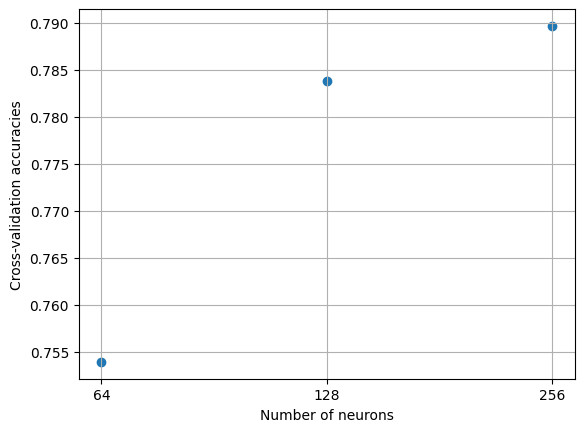

In [95]:
# YOUR CODE HERE
# plot the mean cross-validation accuracies on the final epoch for different number of first hidden-layer neurons.
accuracies_to_plot = [cross_validation_accuracies[neuron] for neuron in num_neurons]

plt.scatter(range(len(num_neurons)), accuracies_to_plot)
plt.xticks(range(len(num_neurons)), num_neurons)
plt.xlabel("Number of neurons")
plt.ylabel("Cross-validation accuracies")
plt.grid(True)  # Add gridlines for better readability
plt.show()

5. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [96]:
optimal_neurons = 256
reason = "My selection for the optimal number of neurons for the hidden layer is 256, as it yielded the highest cross-validation accuracy,as seen on the plot above."

6. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

Epoch: 0, Batch Train Accuracy: 54.29%, Batch Train Loss: 0.6921427845954895, Batch Test Accuracy: 53.90%, Batch Test Loss: 0.6908838748931885
Epoch: 10, Batch Train Accuracy: 70.71%, Batch Train Loss: 0.5684230327606201, Batch Test Accuracy: 67.38%, Batch Test Loss: 0.6351943612098694
Epoch: 20, Batch Train Accuracy: 82.14%, Batch Train Loss: 0.4480088949203491, Batch Test Accuracy: 73.76%, Batch Test Loss: 0.5402467846870422
Epoch: 30, Batch Train Accuracy: 83.57%, Batch Train Loss: 0.3860906958580017, Batch Test Accuracy: 69.50%, Batch Test Loss: 0.6596029996871948
Epoch: 40, Batch Train Accuracy: 78.57%, Batch Train Loss: 0.4510365128517151, Batch Test Accuracy: 78.01%, Batch Test Loss: 0.4770309329032898
Epoch: 50, Batch Train Accuracy: 77.86%, Batch Train Loss: 0.4502201974391937, Batch Test Accuracy: 74.47%, Batch Test Loss: 0.6063018441200256
Epoch: 60, Batch Train Accuracy: 85.71%, Batch Train Loss: 0.35862651467323303, Batch Test Accuracy: 73.05%, Batch Test Loss: 0.650099396

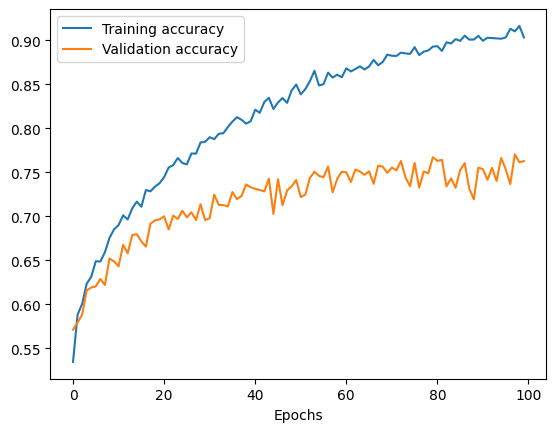

In [97]:
# YOUR CODE HERE
# since find_optimal_hyperparameter function does not return training_accuracies
# (and its recommended not to change the base format of the function)
# created a new function to train the model and get the train and test accuracies
def find_train_and_test_accuracies(X_train, y_train, optimal_neurons):
  # initialise dictonaries required for output
  cross_validation_accuracies = {}
  training_accuracies = {}

  kfold = KFold(n_splits = 2, shuffle=True, random_state = 0)

  for t_samples, v_samples in kfold.split(X_train):
    # X_t = training data for the current fold
    X_t = X_train[t_samples]
    # y_t = corresponding target values (labels) of the training data in the current fold.
    y_t = y_train[t_samples]
    # X_v = validation data for the current fold
    X_v = X_train[v_samples]
    # y_v = corresponding target values (labels) of the validation data in the current fold.
    y_v = y_train[v_samples]

    # to scale the data
    scaler = preprocessing.StandardScaler()

    # Scale the training data and validation data
    X_t_scaled = scaler.fit_transform(X_t)
    X_v_scaled = scaler.transform(X_v)

    # initialisation of NN (MLP takes the neuron value for first layer)
    model = MLP(77, optimal_neurons, 1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_accuracies, train_losses, val_accuracies, val_losses, times = train(model, X_t_scaled, y_t, X_v_scaled, y_v, 256)
    # since just need 1, just break
    break
  cross_validation_accuracies[optimal_neurons] = val_accuracies
  training_accuracies[optimal_neurons] = train_accuracies

  return cross_validation_accuracies, training_accuracies

X_train, y_train = preprocess(df)
test_accuracy, train_accuracy = find_train_and_test_accuracies(X_train.to_numpy(), y_train, optimal_neurons)

plt.plot(train_accuracy[256], label="Training accuracy")
plt.plot(test_accuracy[256], label="Validation accuracy")

plt.xlabel("Epochs")
plt.legend()